Multi Layer Perceptron @ Bengio

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open(file="names.txt", mode="r").read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
word_len = len(words)
word_len

32033

Building character to index and vice-versa mappings

In [4]:
chars = sorted(list(set("".join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


Creating the dataset with context window

In [5]:
window = 3

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * window
    for ch in w + ".":
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


Weight and Bias Initialization

In [6]:
n_embed = 10 # character embedding dims (27, n_embed) 27 because we have 27 character classes
n_hidden = 200 # size of the hidden layer

init_gen = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=init_gen)
W1 = torch.randn((n_embed * window, n_hidden), generator=init_gen) * (5/3) / ((n_embed * window)**0.5)
b1 = torch.randn(n_hidden, generator=init_gen) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=init_gen) * 0.01
b2 = torch.randn(vocab_size, generator=init_gen) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_r = torch.zeros((1, n_hidden))
bnstd_r = torch.ones((1, n_hidden))

params = [C, W1, b1, W2, b2, bngain, bnbias]
print("Parameter count:", sum(p.nelement() for p in params))

for p in params:
  p.requires_grad = True

Parameter count: 12297


Model Training

In [7]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # mini-batch
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=init_gen)
  X_b, Y_b = X_train[ix], Y_train[ix]

  # forward pass
  embed = C[X_b]
  embedcat = embed.view(embed.shape[0], -1)
  hpreact = embedcat @ W1 + b1
  # BatchNorm layer
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  with torch.no_grad():

    bnmean_r = 0.999 * bnmean_r + 0.001 * bnmeani
    bnstd_r = 0.999 * bnstd_r + 0.001 * bnstdi

  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_b)

  # backward pass
  for p in params:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in params:
    p.data += -lr * p.grad

  # stats
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984


KeyboardInterrupt: 

Plotting loss function

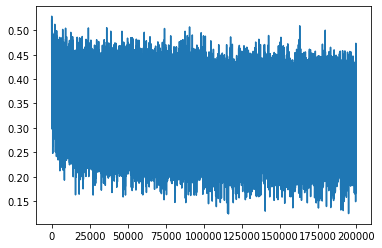

In [53]:
plt.plot(lossi)

In [54]:
@torch.no_grad() # decorator disables gradient tracking
def split_loss(split):
  x, y = {
    'train': (X_train, Y_train),
    'val': (X_dev, Y_dev),
    'test': (X_test, Y_test),
  }[split]

  embed = C[x]
  embedcat = embed.view(embed.shape[0], -1)
  hpreact = embedcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean_r) / bnstd_r + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.06659197807312
val 2.1050572395324707


train: 2.0355966091156006
val: 2.1026782989501953

In [59]:
gen = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0] * window
  while True:

    embed = C[torch.tensor([context])]
    h = torch.tanh(embed.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)

    ix = torch.multinomial(probs, num_samples=1, generator=gen).item()

    context = context[1:] + [ix]
    out.append(ix)

    if ix == 0:
      break

  print("".join(itos[i] for i in out))

nsxablazhbndevagtobixaibhll.
bjuanthvyahldmoumbignfregh.
susklj.
khel.
brugodggssefgadlaymiezlinyfkllmbygh.
lubbigfernastaphann.
briyasamaylynn.
basislayus.
vihriskldwi.
qulphn.
bdumriessafthn.
brudshthassiagubtd.
rsabby.
ddricsllvyiqaslusssklissidrathlangvaclnnhxaughn.
khmberiss.
fennisehmtmilsasn.
prablavahmbern.
braijnnymarlisukamdyl.
had.
zasdy.


*We need to multiply a factor to the initialized weights and biases such that the input std and weight std are roughly the same. We can do this by multiplying layers with (input)^1/2 (dependent on activation fn). Alternatively, we can initialize using torch.nn.init.kaiming_normal (refer docs)

for inference fix the means and std, bias taken care by batch norm

Pytorchifying Code

In [69]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn(size=(fan_in, fan_out), generator=init_gen) / (fan_in**0.5)
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias

    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

In [70]:
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # params trained with backprop
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with running momentum update)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True)
      xvar = x.var(0, keepdim=True, unbiased=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta

    # update
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

In [71]:
class Tanh:

  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

In [72]:
n_embed = 10
n_hidden = 100

init_gen = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=init_gen)
layers = [
  Linear(n_embed * window, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

In [73]:
with torch.no_grad():

  #layers[-1].weight *= 0.1
  layers[-1].gamma *= 0.1

  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

In [74]:
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

47551


In [88]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # mini-batch
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=init_gen)
  X_b, Y_b = X_train[ix], Y_train[ix]

  # forward pass
  embed = C[X_b]
  x = embed.view(embed.shape[0], -1)

  for layer in layers:
    x = layer(x)

  loss = F.cross_entropy(x, Y_b) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad()

  for p in parameters:
    p.grad = None

  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # stats tracking
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

  lossi.append(loss.log10().item())

  with torch.no_grad():
    ud.append([(lr * p.grad.std() / p.data.std()).log().item() for p in parameters])

  if i >= 1000:
    break

      0/ 200000: 2.5222


Visualizing histogram

layer 2 (      Tanh): mean -0.00, std 0.65, saturated: 4.69%
layer 5 (      Tanh): mean -0.01, std 0.67, saturated: 3.97%
layer 8 (      Tanh): mean -0.01, std 0.67, saturated: 3.06%
layer 11 (      Tanh): mean +0.00, std 0.68, saturated: 2.25%
layer 14 (      Tanh): mean -0.01, std 0.68, saturated: 1.31%


Text(0.5, 1.0, 'Activation Distribution')

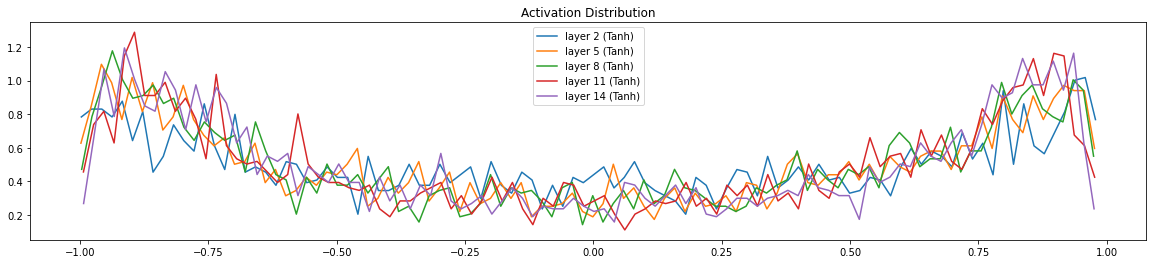

In [89]:
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out
    print("layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("Activation Distribution")

layer 2 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'Gradient Distribution')

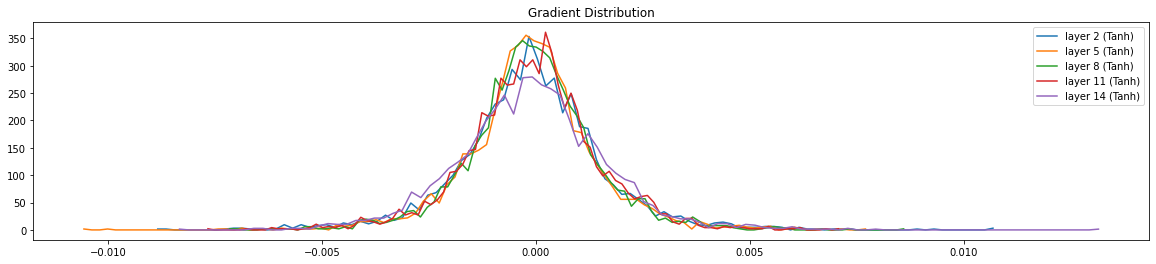

In [90]:
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print("layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("Gradient Distribution")

weight   (27, 10): mean +0.000000, std 6.374127e-03, grad:data ratio 6.214295e-03
weight  (30, 100): mean +0.000091, std 3.874471e-03, grad:data ratio 1.145035e-02
weight (100, 100): mean -0.000010, std 2.373029e-03, grad:data ratio 1.274535e-02
weight (100, 100): mean -0.000007, std 2.125785e-03, grad:data ratio 1.163535e-02
weight (100, 100): mean -0.000005, std 1.996922e-03, grad:data ratio 1.107673e-02
weight (100, 100): mean +0.000004, std 1.997355e-03, grad:data ratio 1.110977e-02
weight  (100, 27): mean -0.000033, std 4.394812e-03, grad:data ratio 1.987052e-02


Text(0.5, 1.0, 'Weight Gradient Distribution')

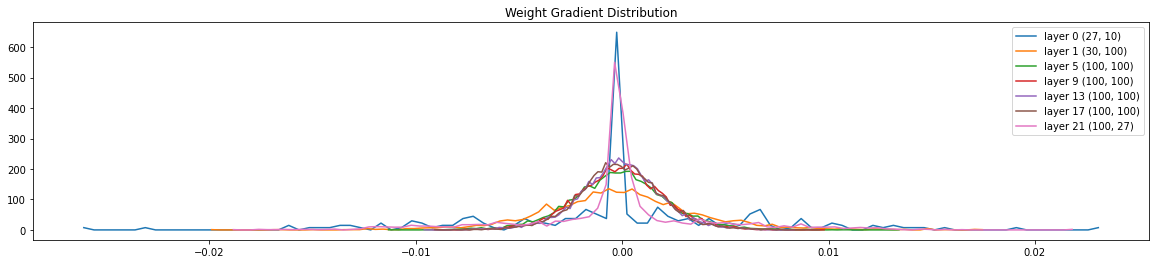

In [91]:
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print("weight %10s: mean %+f, std %e, grad:data ratio %e" % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"layer {i} {tuple(p.shape)}")

plt.legend(legends)
plt.title("Weight Gradient Distribution")

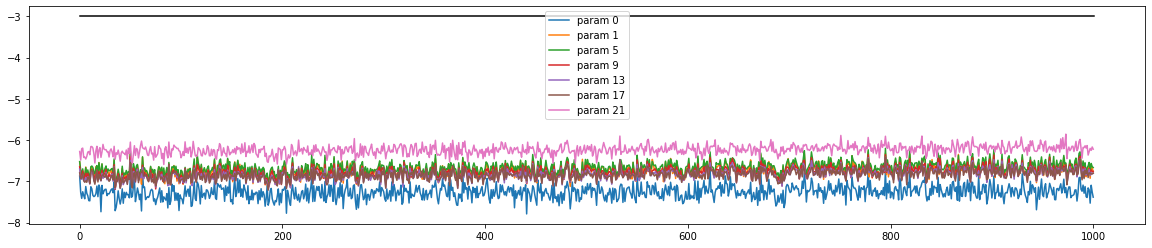

In [92]:
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)

plt.plot([0, len(ud)], [-3, -3], "k") # ratio should be nearly 1e-3
plt.legend(legends)